## Multi-class Classification(oneVsAll)

1. [读取数据](#读取数据)
2. [画出数字](#画出数字)
3. [构建模型](#构建模型)
4. [梯度下降, 固定学习率训练模型](#static)
4. [使用scipy.optimize模块的优化算法进行训练](#使用scipy.optimize模块的优化算法进行训练)

In [1]:
%pylab
%matplotlib inline
import numpy as np
import matplotlib.animation as animation 
import matplotlib.pyplot as plt
from matplotlib import style 
import theano
import theano.tensor as T
import scipy.io as sio
import time

/home/lsr/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


### 读取数据

In [2]:
data = sio.loadmat('ex3data1.mat')
X = data['X'].astype('float32') # (5000, 400)
Y = data['y'] # (5000, 1)
Y = Y * (Y != 10) # 替换10为0
m, n = X.shape
num_labels = 10 # 10个类别

### 画出数字

In [3]:
def displayData(X, example_width=-1):
    if example_width == -1:
        example_width = np.round(np.sqrt(X.shape[1])).astype('int8')
    # 计算每个小图的宽高
    m, n = X.shape
    example_height = (n / example_width)
    
    # 计算整个大拼图的宽高
    display_rows = np.floor(np.sqrt(m))
    display_cols = np.ceil(m / display_rows)
    
    #  小图之间的间隙
    pad = 1

    # 初始化大图矩阵
    display_array = -np.ones([pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)])
    # 装填图像矩阵
    curr_ex = 0
    for j in np.arange(display_rows):
        for i in np.arange(display_cols):
            if curr_ex >= m:
                break
            max_val = np.max(np.abs(X[curr_ex, :]))
            offset_row = int(pad + j * (example_height + pad))
            offset_col = int(pad + i * (example_width + pad))
            display_array[offset_row : offset_row + example_height,
                                     offset_col : offset_col + example_width] = np.reshape(X[curr_ex, :], [20, 20], order='F') / max_val # 按照Fortran顺序reshape(matlab也是按F顺序),或者按照默认的C顺序,然后转置
            curr_ex += 1
        if curr_ex >= m:
            break
    plt.imshow(display_array, cmap=plt.cm.binary_r)
    

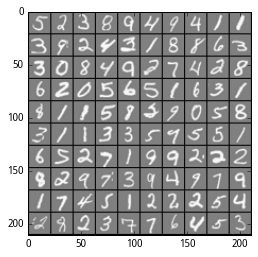

In [4]:
# 随机选择100个数字显示
idx_rand = np.arange(X.shape[0])
np.random.shuffle(idx_rand)
sel = X[idx_rand[0:100], :]
displayData(sel)

In [5]:
# 添加一列1
ones = np.ones([5000, 1], dtype='float32')
X = np.concatenate([ones, X], axis=1) # (5000, 401)

In [6]:
def sigmoid(z):
    return 1 / (1 + T.exp(-z))

### 构建模型

In [7]:
x = theano.shared(X, name = 'x') # (5000, 401)
yy = theano.shared(Y, name = 'y')  # (5000, 1)
yy = T.cast(yy, 'int32') # 这种方法快很多,因为使用普通变量要拷贝1000*10次数据到GPU
k = T.scalar(name='k', dtype='int8') # 当前训练第k个分类器
thetaAll = theano.shared(np.zeros([n + 1, num_labels], dtype='float32')) # (401, 10) 10个分类器的所有参数
alpha = T.scalar('alpha') # 学习率
lambdaReg = T.scalar('lambdaReg') # 正则项系数

y = T.eq(yy, k) # 属于第k类为1,其余为0
theta = (thetaAll[:, k]).dimshuffle(0, 'x') # [401, 1] 只训练第k个分类器的参数
pre_prob = sigmoid(x.dot(theta)) # (5000, 1)
thetaExclude0 = theta[1:, :]  # 不惩罚theta[0, 0] 
loss = T.mean(-y * T.log(pre_prob) - (1 - y) * T.log(1 - pre_prob)) + \
                lambdaReg * (thetaExclude0 ** 2).sum() / (2 * x.shape[0]) #  不对theta[0]正则化
grad_auto = T.grad(loss, thetaAll) # 对所有参数求导,不参与计算的倒数为0
gradient_step_auto = theano.function([alpha, lambdaReg, k],
                                     updates={thetaAll : thetaAll - alpha * grad_auto}) # 梯度下降更新参数
calcLoss = theano.function([lambdaReg, k], loss)
calcGrad= theano.function([lambdaReg, k], grad_auto)

In [8]:
# 模型预测
pre_prob_All = sigmoid(x.dot(thetaAll)) # (5000, 10)
preIndex =  T.argmax(pre_prob_All, axis=1) # (5000,) 预测结果
total = T.neq(yy.T, preIndex)
accuracy = 1 - (total.sum() / float(m)) # 准确率
calcAccur = theano.function([], accuracy)

In [9]:
grad_auto.eval({ k : 1, lambdaReg : 1}) # 计算第k个分类器参数的梯度, 可验证其他分类器参数的梯度为0

CudaNdarray([[  0.00000000e+00   3.99999797e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   1.73334763e-06   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -2.06052547e-07   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]])

### 梯度下降, 固定学习率训练模型<span id='static'/>

In [10]:
# 固定学习率, 训练模型, 计算耗时和准确率, 纯粹梯度下降，准确率太低
thetaAll.set_value(np.zeros([n + 1, num_labels], dtype='float32')) # (401, 10)
max_iters = 1000
lambdaInit = 1
alphaVal = 0.01
J_history = np.zeros((max_iters, 1))
start_time = time.time()
for j in range(num_labels): # 训练num_labels个分类器
    for i in range(max_iters):
        gradient_step_auto(alphaVal, lambdaInit, j)
end_time = time.time()
print 'training cost %.2f s' % (end_time - start_time)
print 'training set accuracy is %.2f ' % (calcAccur())

training cost 14.49 s
training set accuracy is 0.84 


### 使用scipy.optimize模块的优化算法进行训练

In [11]:
# 计算指定theta时的cost,使用optimize的函数时,传入的待优化参数是一个一维向量,所以要转成二维列向量,并且使用fmin时还需要转成float32类型
def computeCost(theta_value, j):
    thetaAll.set_value(theta_value.reshape(n + 1, num_labels).astype('float32'))
    return calcLoss(lambdaInit, j)

# 计算指定theta时的梯度
def train_fn_grad(theta_value, j):
    thetaAll.set_value(theta_value.reshape(n + 1, num_labels).astype('float32'))
    return np.array(calcGrad(lambdaInit, j)).flatten() # 梯度也要转为一维向量


def fitModel():
    # 使用共轭梯度法优化
    thetaV = [] # 存储每一次迭代后的结果
    thetaSaved = np.zeros([n + 1, num_labels], dtype='float32')
    for j in range(num_labels): # 训练num_labels个分类器
        thetaValue = optimize.fmin_cg( # or fmin_bfgs
            f=computeCost,
            x0=np.zeros([n + 1, num_labels], dtype='float32'),
            fprime=train_fn_grad,
            args=(j ,),
            disp=1,
            maxiter=1000
        )
        thetaSaved[:, j] = thetaValue.reshape(n + 1, num_labels)[:, j]
    return thetaSaved


In [12]:
from scipy import optimize
start_time = time.time()
thetaValue = fitModel()
end_time = time.time()
print 'training cost %.2f s' % (end_time - start_time)
thetaAll.set_value(thetaValue)
print 'training set accuracy is %.2f ' % (calcAccur())  # 准确率与matlab中结果一样

Optimization terminated successfully.
         Current function value: 0.020148
         Iterations: 90
         Function evaluations: 380
         Gradient evaluations: 380
Optimization terminated successfully.
         Current function value: 0.026961
         Iterations: 89
         Function evaluations: 428
         Gradient evaluations: 428
         Current function value: 0.068444
         Iterations: 95
         Function evaluations: 353
         Gradient evaluations: 342
Optimization terminated successfully.
         Current function value: 0.071706
         Iterations: 124
         Function evaluations: 350
         Gradient evaluations: 350
Optimization terminated successfully.
         Current function value: 0.052051
         Iterations: 113
         Function evaluations: 411
         Gradient evaluations: 411
Optimization terminated successfully.
         Current function value: 0.076859
         Iterations: 114
         Function evaluations: 345
         Gradient evaluati